# Image classification from scratch (ゼロからの画像分類)

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2020/04/28<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## 序章

この例では、ディスク上のJPEG画像ファイルから、事前に学習された重みや既製のKeras Applicationモデルを利用せずに、ゼロから画像分類を行う方法を示します。  
このワークフローは、Kaggle Cats vs Dogsバイナリ分類データセットで実演しています。  

データセットの生成には`image_dataset_from_directory`ユーティリティを使用し、画像の標準化とデータの増強にはKerasの画像前処理レイヤーを使用しています。

## 設定

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## データの読み込み：「Cats vs Dogs」のデータセット

### 生データのダウンロード

まず、生データの786MのZIPアーカイブをダウンロードしてみましょう。

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  36.4M      0  0:00:21  0:00:21 --:--:-- 39.4M


In [3]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

replace MSR-LA - 3467.docx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
3D_image_classification.ipynb           captcha_ocr.ipynb
MSR-LA - 3467.docx                      image_classification_from_scratch.ipynb
PetImages                               kagglecatsanddogs_3367a.zip
adamatch.ipynb                          mnist_convnet.ipynb
autoencoder.ipynb                       oxford_pets_image_segmentation.ipynb
captcha_images_v2                       readme[1].txt
captcha_images_v2.zip


これで、`PetImages`フォルダができて、`Cat`と`Dog`という2つのサブフォルダができました。  
それぞれのサブフォルダには、各カテゴリの画像ファイルが入っています。

In [4]:
!ls PetImages

Cat Dog


### 破損された画像のフィルタリング

たくさんの画像データを扱っていると、画像が壊れてしまうことがよくあります。  
ここでは、ヘッダに「JFIF」という文字列が含まれていない、エンコードの悪い画像をフィルタリングしてみましょう。

In [5]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 1590 images


## `Dataset` を生成します

In [6]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


## データの可視化

これは、トレーニングデータセットの最初の9枚の画像です。ご覧の通り、ラベル1は「犬」、ラベル0は「猫」です。

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


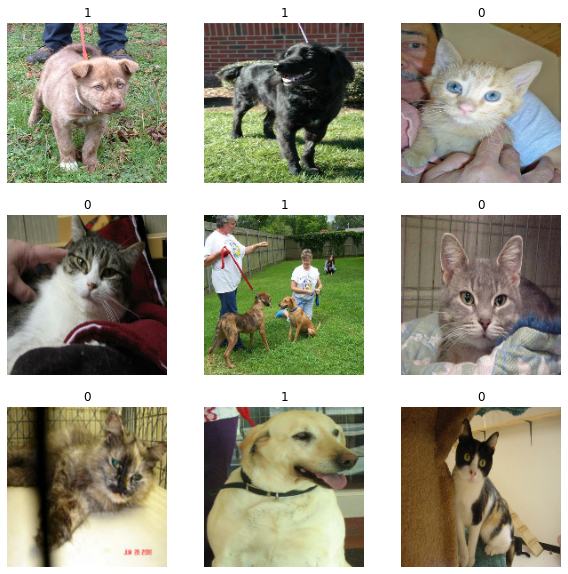

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## 画像データの補強を利用する

大規模な画像データセットがない場合は、ランダムな水平反転や小さなランダムな回転など、ランダムでありながら現実的な変換をトレーニング画像に適用することで、サンプルの多様性を人工的に導入するのが良い方法です。
これにより、学習データのさまざまな側面をモデルに反映させることができ、オーバーフィッティングを抑制することができます。

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

データセットの最初の画像に`data_augmentation`を繰り返し適用して、オーグメンテーションされたサンプルがどのように見えるかを視覚化してみましょう。

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


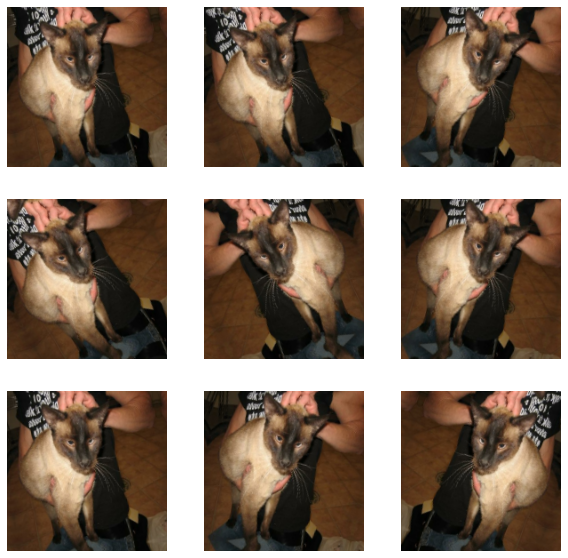

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## データの標準化

画像は，データセットから連続した `float32` のバッチとして出力されているので，すでに標準的なサイズ (180x180) になっています。
しかし，画像のRGBチャンネルの値は，`[0, 255]`の範囲にあります。
これはニューラルネットワークにとって理想的ではありません。一般的には、入力値を小さくするようにすべきです。
ここでは、モデルの最初に `Rescaling` レイヤーを使用して、値が `[0, 1]` の範囲になるように標準化します

## データの前処理に2つのオプション

`data_augmentation`プリプロセッサを使用する方法は2つあります。

**オプション1：モデルの一部にする**こんな感じです。

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
...  # Rest of the model
```

このオプションを使用すると、データ拡張はデバイス上で、モデルの他の実行と同期して行われるため、GPUアクセラレーションの恩恵を受けることができます。  

データ増強はテスト時には無効であることに注意してください。つまり、入力サンプルは `fit()` の間だけ増強され、`evaluate()` や `predict()` を呼び出すときには増強されません。  

GPUでトレーニングするなら、こちらの方が良いでしょう。

**オプション2：データセット**に適用することで、以下のような拡張画像のバッチを生成するデータセットを得る。

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

このオプションを使用すると、データ拡張は **CPU上** で非同期に行われ、モデルに入る前にバッファリングされます。  

CPUでトレーニングを行う場合は、データ拡張を非同期かつノンブロッキングで行うことができるこの方法が良いでしょう。  

ここでは、第1の選択肢を採用します。

## パフォーマンスのためのデータセットの設定

I/Oがブロック化することなくディスクからデータを取り出せるように、バッファードプリフェッチを使用するようにしましょう。

In [10]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## モデルの構築

Xceptionネットワークの小さなバージョンを構築します。  
特にアーキテクチャの最適化は行っていません。最適なモデル構成を系統的に探索したい場合は、[Keras Tuner](https://github.com/keras-team/keras-tuner)の利用を検討してください。

- モデルは，プリプロセッサである「data_augmentation」から始まり，次に「Rescaling」レイヤーが続きます．
- 最終的な分類レイヤーの前には、`Dropout`レイヤーがあります。

In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## モデルのトレーニング

In [12]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 5:39 - loss: 0.7473 - accuracy: 0.5808

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


325/586 [===============>..............] - ETA: 5:03 - loss: 0.7436 - accuracy: 0.5819

403/586 [===================>..........] - ETA: 3:31 - loss: 0.7348 - accuracy: 0.5855

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 3:20 - loss: 0.7339 - accuracy: 0.5859

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 3:06 - loss: 0.7326 - accuracy: 0.5865

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 2:58 - loss: 0.7319 - accuracy: 0.5868

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.7174 - accuracy: 0.5949WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2e7b665e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 733s 1s/step - loss: 0.7173 - accuracy: 0.5949 - val_loss: 0.6036 - val_accuracy: 0.6719
Epoch 2/50


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 5:34 - loss: 0.5515 - accuracy: 0.7155

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


325/586 [===============>..............] - ETA: 4:59 - loss: 0.5503 - accuracy: 0.7168

403/586 [===================>..........] - ETA: 3:29 - loss: 0.5468 - accuracy: 0.7200

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 3:19 - loss: 0.5464 - accuracy: 0.7203

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 3:05 - loss: 0.5459 - accuracy: 0.7208

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 2:57 - loss: 0.5456 - accuracy: 0.7211

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 1s - loss: 0.5385 - accuracy: 0.7272

全データセットで50エポックのトレーニングを行った結果、96%の検証精度を得ることができました。

## 新しいデータで推論を行う

なお、データオーグメンテーションとドロップアウトは、推論時には不活性である。

In [1]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

NameError: name 'keras' is not defined